<a href="https://colab.research.google.com/github/neethipoonacha/EIP3/blob/master/Gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# https://keras.io/
!pip install -q keras
import keras


!pip install Pillow
import scipy

In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation,Add, SpatialDropout2D,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,Convolution2D
import warnings
from keras.layers import Concatenate , Activation
%matplotlib inline
%config InlineBackend.figure_format='retina'
from keras.optimizers import SGD, Nadam, Adam
from keras.callbacks import  EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
#import numpy as np
#from scipy.misc import imread, imsave, imresize


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, balanced_accuracy_score, accuracy_score

from keras.utils import np_utils

#pip install git+https://github.com/qubvel/classification_models.git

## Load the trained RESNET-18 model [ Change the input to CIFAR-10 input (32,32,3) instead of (224,224,3)]\n",
#from classification_models.resnet import ResNet18, preprocess_input       
#model = ResNet18((32, 32, 3), weights='imagenet', classes=10, include_top=False)



In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 50
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [18]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print (x_train.shape)


#X_train, Y_train, X_test, Y_test = get_mnist_data()
#classes = get_cifar10_labels()

#show_examples(X_train[:10],Y_train[:10],classes)


(50000, 32, 32, 3)


In [0]:
def plot_model_history(model_history, clip_beginning=0):
    fig, axs = plt.subplots(1,2,figsize=(18,6))
    # summarize history for accuracy
    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    axs[0].plot(range(clip_beginning+1,len(acc)+1),acc[clip_beginning:])
    axs[0].plot(range(clip_beginning+1,len(val_acc)+1),val_acc[clip_beginning:])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(clip_beginning+1,len(acc)+1),len(acc)/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    axs[1].plot(range(clip_beginning+1,len(loss)+1),loss[clip_beginning:])
    axs[1].plot(range(clip_beginning+1,len(val_loss)+1),val_loss[clip_beginning:])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(clip_beginning+1,len(loss)+1),len(loss)/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

def show_examples(X,y,classes):
    rows = int(np.ceil(len(X)/5))
    if X.shape[1] > 64:
        multiplier = 2
    else:
        multiplier = 1
    fig = plt.figure(figsize=(10*multiplier, rows*2*multiplier))
    for idx in np.arange(len(X)):
        img = X[idx]
        assert (len(img.shape)==3 and img.shape[2] in [1,3,4]) or len(img.shape)==2
        ax = fig.add_subplot(rows, 5, idx + 1, xticks=[], yticks=[])
        cmap = None
        if (len(img.shape)==3 and img.shape[2]==1) or len(img.shape)==2:
            cmap="binary"
        if len(img.shape)==3 and img.shape[2]==1:
            img = img.reshape((img.shape[0],img.shape[1]))
        ax.imshow(img,cmap=cmap)
        ax.set_title(classes[np.argmax(y[idx])])
    plt.show()


def show_misclassified(X, Y_ohe, Y_pred, classes,
                       columns=5, total=25,
                       pick_randomly=True, image_size_multiplier=4):
    y_true = np.argmax(Y_ohe, axis=1)
    yp = np.argmax(Y_pred, axis=1)
    misclassified = y_true != yp
    X = X[misclassified]
    Y_ohe = Y_ohe[misclassified]
    Y_pred = Y_pred[misclassified]
    y_true = y_true[misclassified]
    yp = yp[misclassified]
    total = min(total, len(X))
    rows = int(np.ceil(total / columns))

    indexes = np.random.choice(len(X), total, replace=False) if pick_randomly else list(range(0, total))

    X = np.take(X, indexes, axis=0)
    Y_ohe = np.take(Y_ohe, indexes, axis=0)
    Y_pred = np.take(Y_pred, indexes, axis=0)
    y_true = np.take(y_true, indexes, axis=0)
    yp = np.take(yp, indexes, axis=0)

    fig_height = rows * image_size_multiplier * 2
    fig_width = columns * image_size_multiplier

    fig = plt.figure(figsize=(fig_width, fig_height))
    plt.subplots_adjust(bottom=0.1, top=1.0)
    idx1 = 0
    idx2 = 0
    jdx = 0
    for row in range(rows):
        for column in range(columns):
            if idx1 >= len(X):
                break
            img = X[idx1]
            assert (len(img.shape) == 3 and img.shape[2] in [1, 3, 4]) or len(img.shape) == 2
            ax = fig.add_subplot(rows * 2, columns, jdx + 1, xticks=[], yticks=[])
            cmap = None
            if (len(img.shape) == 3 and img.shape[2] == 1) or len(img.shape) == 2:
                cmap = "binary"
            if len(img.shape) == 3 and img.shape[2] == 1:
                img = img.reshape((img.shape[0], img.shape[1]))
            ax.imshow(img, cmap=cmap)
            ax.set_xlabel("Predicted = %s, Actual = %s" % (classes[yp[idx1]], classes[y_true[idx1]]))
            idx1 += 1
            jdx += 1

        for column in range(columns):
            if idx2 >= len(Y_pred):
                break
            yps = Y_pred[idx2]
            ax = fig.add_subplot(rows * 2, columns, jdx + 1, xticks=[], yticks=[])
            ind = np.arange(len(classes))
            rects = ax.bar(ind, yps, 0.25, label='Labels')
            ax.set_ylabel('Probability')
            ax.set_yticks(np.arange(0, 1.2, 0.2))
            ax.set_xticks(ind)
            ax.set_xticklabels(classes, rotation=90, ha='left')
            ax.legend()
            ax.tick_params(axis='both', which='major', labelsize=8)
            ax.tick_params(axis='both', which='minor', labelsize=6)
            idx2 += 1
            jdx += 1
    plt.show()
    
    
def get_cifar10_labels():
    return ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


def get_cifar10_data(preprocess=False):
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    num_classes = len(np.unique(y_train))
    X_train, y_train = shuffle(X_train, y_train)
    X_test, y_test = shuffle(X_test, y_test)

    if preprocess:
        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')
        X_train /= 255
        X_test /= 255

    Y_train = np_utils.to_categorical(y_train, num_classes)
    Y_test = np_utils.to_categorical(y_test, num_classes)
    return X_train, Y_train, X_test, Y_test

In [0]:
def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    pyplot.show()

In [0]:
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()
show_imgs(x_test[:50])

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( rotation_range=90, 
                 width_shift_range=0.1, height_shift_range=0.1, 
                 horizontal_flip=True) 
datagen.fit(x_train)

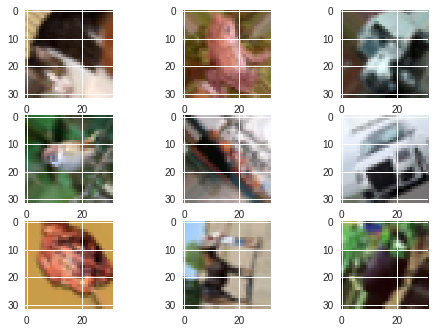

In [0]:
from matplotlib import pyplot as plt
# Configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(toimage(X_batch[i].reshape(x_train.shape[1], x_train.shape[2], 3)))
    # show the plot
    pyplot.show()
    break

In [0]:
# Dense Block
def add_denseblock(input, num_filter = 64, dropout_rate=0.0, weight_decay=1e-4):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [0]:
def add_transition(input, num_filter = 32, dropout_rate = 0.1):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [24]:
num_filter = 32
dropout_rate = 0.2
l = 15
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)
dropout_rate = 0.1
Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

#Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)

output = output_layer(Third_Transition)


W0715 06:17:13.967132 139694435338112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0715 06:17:13.969119 139694435338112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0715 06:17:13.982714 139694435338112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0715 06:17:14.019022 139694435338112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0715 06:17:14.019929 1396944353

In [25]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [26]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.1 ,decay=1e-4,momentum=0.9),
              metrics=['accuracy'])

W0715 06:17:32.627328 139694435338112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
def lr_schedule(epoch):
    lrate = 0.1
    if epoch > 32:
        lrate = 0.15
    elif epoch > 48:
        lrate = 0.2        
    return lrate

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( rotation_range=90, 
                 width_shift_range=0.1, height_shift_range=0.1, 
                 horizontal_flip=True) 
datagen.fit(x_train)

In [29]:
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                       #       patience=5, min_lr=0.001)


#training
batch_size = 128

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=30,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

#model.save_weights('drive/My\ Drive/test/weight-01-0.33.hdf5')

W0715 06:17:44.108652 139694435338112 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
390/390 [==============================] - 164s 420ms/step - loss: 1.8164 - acc: 0.3336 - val_loss: 2.4783 - val_acc: 0.2942
Epoch 2/30
390/390 [==============================] - 153s 392ms/step - loss: 1.6231 - acc: 0.4097 - val_loss: 1.7181 - val_acc: 0.4217
Epoch 3/30
390/390 [==============================] - 152s 389ms/step - loss: 1.5109 - acc: 0.4482 - val_loss: 1.6758 - val_acc: 0.4331
Epoch 4/30
390/390 [==============================] - 152s 390ms/step - loss: 1.4120 - acc: 0.4925 - val_loss: 2.0508 - val_acc: 0.4268
Epoch 5/30
390/390 [==============================] - 152s 390ms/step - loss: 1.3219 - acc: 0.5231 - val_loss: 1.4281 - val_acc: 0.5143
Epoch 6/30
390/390 [==============================] - 152s 390ms/step - loss: 1.2454 - acc: 0.5521 - val_loss: 2.3530 - val_acc: 0.4343
Epoch 7/30
390/390 [==============================] - 152s 389ms/step - loss: 1.1900 - acc: 0.5747 - val_loss: 2.0872 - val_acc: 0.4591
Epoch 8/30
390/390 [============================

In [0]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_one_save.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
from google.colab import files

files.download('DNST_model_one_save.h5')

In [0]:
#imgAug = ImageDataGenerator(rotation_range=60,width_shift_range=0.1, zoom_range=0.1,horizontal_flip=True, height_shift_range=0.1)
#imgAug.fit(x_train)

#data augmentation
datagen = ImageDataGenerator(
    horizontal_flip=True
    )
datagen.fit(x_train)

In [0]:

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                          #    patience=5, min_lr=0.001)

model.load_weights("DNST_model_one_save.h5")

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.15 ,decay=1e-6,momentum=0.9),
              metrics=['accuracy'])

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch= 2*x_train.shape[0] // batch_size,epochs=20,\
                    verbose=1,validation_data=(x_test,y_test))


model.save_weights("DNST_model_two_save.h5")


Epoch 1/20
781/781 [==============================] - 588s 753ms/step - loss: 0.5403 - acc: 0.8141 - val_loss: 0.9019 - val_acc: 0.7562
Epoch 2/20
781/781 [==============================] - 576s 738ms/step - loss: 0.4472 - acc: 0.8458 - val_loss: 0.8675 - val_acc: 0.7347
Epoch 3/20
781/781 [==============================] - 576s 738ms/step - loss: 0.3924 - acc: 0.8644 - val_loss: 0.6566 - val_acc: 0.8014
Epoch 4/20
781/781 [==============================] - 577s 739ms/step - loss: 0.3573 - acc: 0.8777 - val_loss: 0.4442 - val_acc: 0.8588
Epoch 5/20
781/781 [==============================] - 580s 743ms/step - loss: 0.3299 - acc: 0.8851 - val_loss: 0.6905 - val_acc: 0.8004
Epoch 6/20
781/781 [==============================] - 580s 743ms/step - loss: 0.3096 - acc: 0.8943 - val_loss: 0.5004 - val_acc: 0.8469
Epoch 7/20
781/781 [==============================] - 579s 742ms/step - loss: 0.2838 - acc: 0.9020 - val_loss: 0.4306 - val_acc: 0.8645
Epoch 8/20
781/781 [============================

In [0]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 26s 3ms/step
Test loss: 0.44008580334186553
Test accuracy: 0.8854


In [0]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_two_save.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
from google.colab import files

files.download('DNST_model_two_save.h5')

In [0]:
#data augmentation
datagen = ImageDataGenerator(    
    horizontal_flip=True
    )
datagen.fit(x_train)



In [0]:

model.load_weights("DNST_model_two_save.h5")

batch_size=64

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01 ,decay=1e-10,momentum=0.9),
              metrics=['accuracy'])

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch= x_train.shape[0] // batch_size,epochs=10,\
                    verbose=1,validation_data=(x_test,y_test))


model.save_weights("DNST_model_three_save.h5")

Epoch 1/10
781/781 [==============================] - 350s 448ms/step - loss: 0.1176 - acc: 0.9587 - val_loss: 0.3127 - val_acc: 0.9141
Epoch 2/10
781/781 [==============================] - 335s 429ms/step - loss: 0.1086 - acc: 0.9612 - val_loss: 0.3145 - val_acc: 0.9190
Epoch 3/10
781/781 [==============================] - 336s 430ms/step - loss: 0.0967 - acc: 0.9655 - val_loss: 0.3121 - val_acc: 0.9176
Epoch 4/10
781/781 [==============================] - 337s 431ms/step - loss: 0.0939 - acc: 0.9664 - val_loss: 0.3244 - val_acc: 0.9190
Epoch 5/10
781/781 [==============================] - 337s 432ms/step - loss: 0.0914 - acc: 0.9677 - val_loss: 0.3342 - val_acc: 0.9189
Epoch 6/10
781/781 [==============================] - 337s 432ms/step - loss: 0.0910 - acc: 0.9672 - val_loss: 0.3264 - val_acc: 0.9190
Epoch 7/10
781/781 [==============================] - 337s 431ms/step - loss: 0.0845 - acc: 0.9701 - val_loss: 0.3266 - val_acc: 0.9198
Epoch 8/10
781/781 [============================

In [30]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 9s 934us/step
Test loss: 1.1032885452270509
Test accuracy: 0.693


In [31]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_three_save.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
from google.colab import files

files.download('DNST_model_three_save.h5')

In [0]:
#datagen = ImageDataGenerator(
  #  horizontal_flip=True
  #  )
#datagen.fit(x_train)



model.load_weights("DNST_model_three_save.h5")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
batch_size=64

#model.compile(loss='categorical_crossentropy',
            #  optimizer=SGD(lr=0.001 ,decay=1e-4,momentum=0.9),
            #  metrics=['accuracy'])

model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=250,
                    verbose=1,
                    validation_data=(x_test, y_test),callbacks=[reduce_lr])

model.save_weights("DNST_model_four_save.h5")

Train on 50000 samples, validate on 10000 samples
Epoch 1/250
50000/50000 [==============================] - 346s 7ms/step - loss: 0.0758 - acc: 0.9726 - val_loss: 0.3350 - val_acc: 0.9206
Epoch 2/250
50000/50000 [==============================] - 336s 7ms/step - loss: 0.0735 - acc: 0.9739 - val_loss: 0.3293 - val_acc: 0.9212
Epoch 3/250
50000/50000 [==============================] - 336s 7ms/step - loss: 0.0722 - acc: 0.9738 - val_loss: 0.3332 - val_acc: 0.9208
Epoch 4/250
50000/50000 [==============================] - 336s 7ms/step - loss: 0.0719 - acc: 0.9747 - val_loss: 0.3340 - val_acc: 0.9206
Epoch 5/250
50000/50000 [==============================] - 336s 7ms/step - loss: 0.0729 - acc: 0.9742 - val_loss: 0.3331 - val_acc: 0.9212
Epoch 6/250
50000/50000 [==============================] - 336s 7ms/step - loss: 0.0725 - acc: 0.9740 - val_loss: 0.3334 - val_acc: 0.9204
Epoch 7/250
50000/50000 [==============================] - 336s 7ms/step - loss: 0.0740 - acc: 0.9730 - val_loss: 0.

KeyboardInterrupt: ignored

In [0]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 26s 3ms/step
Test loss: 0.3363751113705337
Test accuracy: 0.9209


In [0]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_four_save.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
from google.colab import files

files.download('DNST_model_four_save.h5')

In [0]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 26s 3ms/step
Test loss: 0.3363751113705337
Test accuracy: 0.9209


Weights are loaded and saved from disk ,Due to security issues was not able to  connect to google drive via office network

DNST_model_one_save.h5   https://drive.google.com/file/d/1ZqTvWcSFZV9xDFoSo2vZHX1Z0spPbSey/view?usp=sharing

DNST_model_two_save.h5 https://drive.google.com/file/d/1p0wLKjl-h6pU4-mQmwDPHGGGMhTtQOjJ/view?usp=sharing

DNST_model_three_save.h5 https://drive.google.com/file/d/1DIsnAVvePizUNZH-sQjPSQpifDjBT1DP/view?usp=sharing

DNST_model_four_save.h5 https://drive.google.com/file/d/1wIE1QARyX8A8HW0AvZNHtAkjwvHKOtoG/view?usp=sharing


In [0]:
def inspect_predictions(score, predictions,labels, classes, print_results=False, plot_results=True):

    test_score = score
    test_predictions = predictions

    test_predictions = np.argmax(test_predictions, axis=1)
    test_predictions = [classes[p] for p in test_predictions]

    y_test = np.argmax(labels, axis=1)
    y_test = [classes[p] for p in y_test]

    test_precision,test_recall,test_f1,test_support = precision_recall_fscore_support(y_test, test_predictions, average=None, labels=classes)

    results = pd.DataFrame({"classes": classes,
                                 "average":[None]*len(test_precision),
                                  "precision": test_precision,
                                  "recall": test_recall,
                                  "support": test_support,
                                  "data_source": ["test"] * len(test_precision)})

    test_precision, test_recall, test_f1, test_support = precision_recall_fscore_support(y_test, test_predictions,
                                                                                         average='micro', labels=classes)

    results_test = pd.DataFrame({"classes": [None],
                                 "average":['micro'],
                                  "precision": [test_precision],
                                  "recall": [test_recall],
                                  "support": [test_support],
                                  "data_source": ["test"]})

    results = pd.concat((results,results_test))

    # =======

    test_precision, test_recall, test_f1, test_support = precision_recall_fscore_support(y_test, test_predictions,
                                                                                         average='macro',
                                                                                         labels=classes)

    results_test = pd.DataFrame({"classes": [None],
                                 "average": ['macro'],
                                 "precision": [test_precision],
                                 "recall": [test_recall],
                                 "support": [test_support],
                                 "data_source": ["test"]})

    results = pd.concat((results, results_test))

    # ==============
    test_precision, test_recall, test_f1, test_support = precision_recall_fscore_support(y_test, test_predictions,
                                                                                         average='weighted',
                                                                                         labels=classes)

    results_test = pd.DataFrame({"classes": [None],
                                 "average": ['weighted'],
                                 "precision": [test_precision],
                                 "recall": [test_recall],
                                 "support": [test_support],
                                 "data_source": ["test"]})

    results = pd.concat((results, results_test))
    cm = confusion_matrix(y_test, test_predictions)
    balanced_accuracy = balanced_accuracy_score(y_test, test_predictions)
    accuracy = accuracy_score(y_test, test_predictions)


    if print_results:
        print(" =-= " * 20)
        print("Score = ", test_score)
        print("Balanced Accuracy = {:2.2f}%, Accuracy = {:2.2f}%".format(balanced_accuracy * 100, accuracy*100))


    if plot_results:
        print()
        plt.figure(figsize=(16,6))
        sns.barplot(x="classes",y="precision",data=results[~pd.isna(results.classes)])
        lower_bound = max(results['precision'].min() - 0.05,0)
        upper_bound = 1.05
        plt.ylim((lower_bound,upper_bound))
        plt.title("Precision per Class")
        plt.show()

        plt.figure(figsize=(16, 6))
        sns.barplot(x="classes", y="recall", data=results[~pd.isna(results.classes)])
        lower_bound = max(results['recall'].min() - 0.05, 0)
        upper_bound = 1.05
        plt.ylim((lower_bound, upper_bound))
        plt.title("Recall per Class")
        plt.show()

        cmap = plt.get_cmap('Blues')
        figsize = 6*int(np.ceil(len(classes)/10))
        fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(figsize,figsize))
        im = ax.imshow(cm, cmap=cmap)  # Plot the confusion matrix

        # Show all ticks
        ax.set_xticks(np.arange(len(cm[0])))
        ax.set_yticks(np.arange(len(cm[1])))

        ax.set_xticklabels(classes)
        ax.set_yticklabels(classes)

        # Label each axis
        ax.set_ylabel("True Label")
        ax.set_xlabel("Predicted label\n\nAccuracy={:2.2f}% ".format(balanced_accuracy * 100))
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        fig.tight_layout()
        ax.set_title("Confusion Matrix")
        thresh = cm.max() / 2
        for i in range(len(cm[0])):
            for j in range(len(cm[1])):
                text = ax.text(i, j, cm[i, j],ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
        plt.show()

    return test_score,results


def evaluate(model, X_test, Y_test, classes,datagen=None, print_results=False, plot_results=True):
    # TODO: Graph P-R-F1 per class for seeing where we fail most
    # TODO: print class with lowest and highest P-R-F1

    assert (X_test is not None and Y_test is not None) or (datagen is not None)
    if datagen is not None:
        X_test, Y_test = datagen.next()
    test_score = model.evaluate(X_test, Y_test, verbose=0)
    test_predictions = model.predict(X_test)
    return inspect_predictions(test_score, test_predictions,labels=Y_test,classes=classes,
                               print_results=print_results, plot_results=plot_results)


def plot_model_history(model_history, clip_beginning=0):
    fig, axs = plt.subplots(1,2,figsize=(18,6))
    # summarize history for accuracy
    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    axs[0].plot(range(clip_beginning+1,len(acc)+1),acc[clip_beginning:])
    axs[0].plot(range(clip_beginning+1,len(val_acc)+1),val_acc[clip_beginning:])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(clip_beginning+1,len(acc)+1),len(acc)/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    axs[1].plot(range(clip_beginning+1,len(loss)+1),loss[clip_beginning:])
    axs[1].plot(range(clip_beginning+1,len(val_loss)+1),val_loss[clip_beginning:])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(clip_beginning+1,len(loss)+1),len(loss)/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [42]:
iterator = datagen.flow(x_train, y_train, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(x_train, y_train, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))

# Inspect Predictions helps you see the precision recall and confusion matrix
_ = inspect_predictions(score, predictions,y_train, classes=get_cifar10_labels(),print_results=True, plot_results=False)

 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.8989018533325195, 0.7149199995994567]
Balanced Accuracy = 71.20%, Accuracy = 71.20%


In [47]:
iterator = datagen.flow(x_test, y_test, batch_size=1024, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(x_test, y_test, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))

_ = inspect_predictions(score, predictions,y_test, classes=get_cifar10_labels(),print_results=True, plot_results=False)

 =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-=  =-= 
Score =  [0.9793549554824829, 0.692799999332428]
Balanced Accuracy = 69.71%, Accuracy = 69.71%


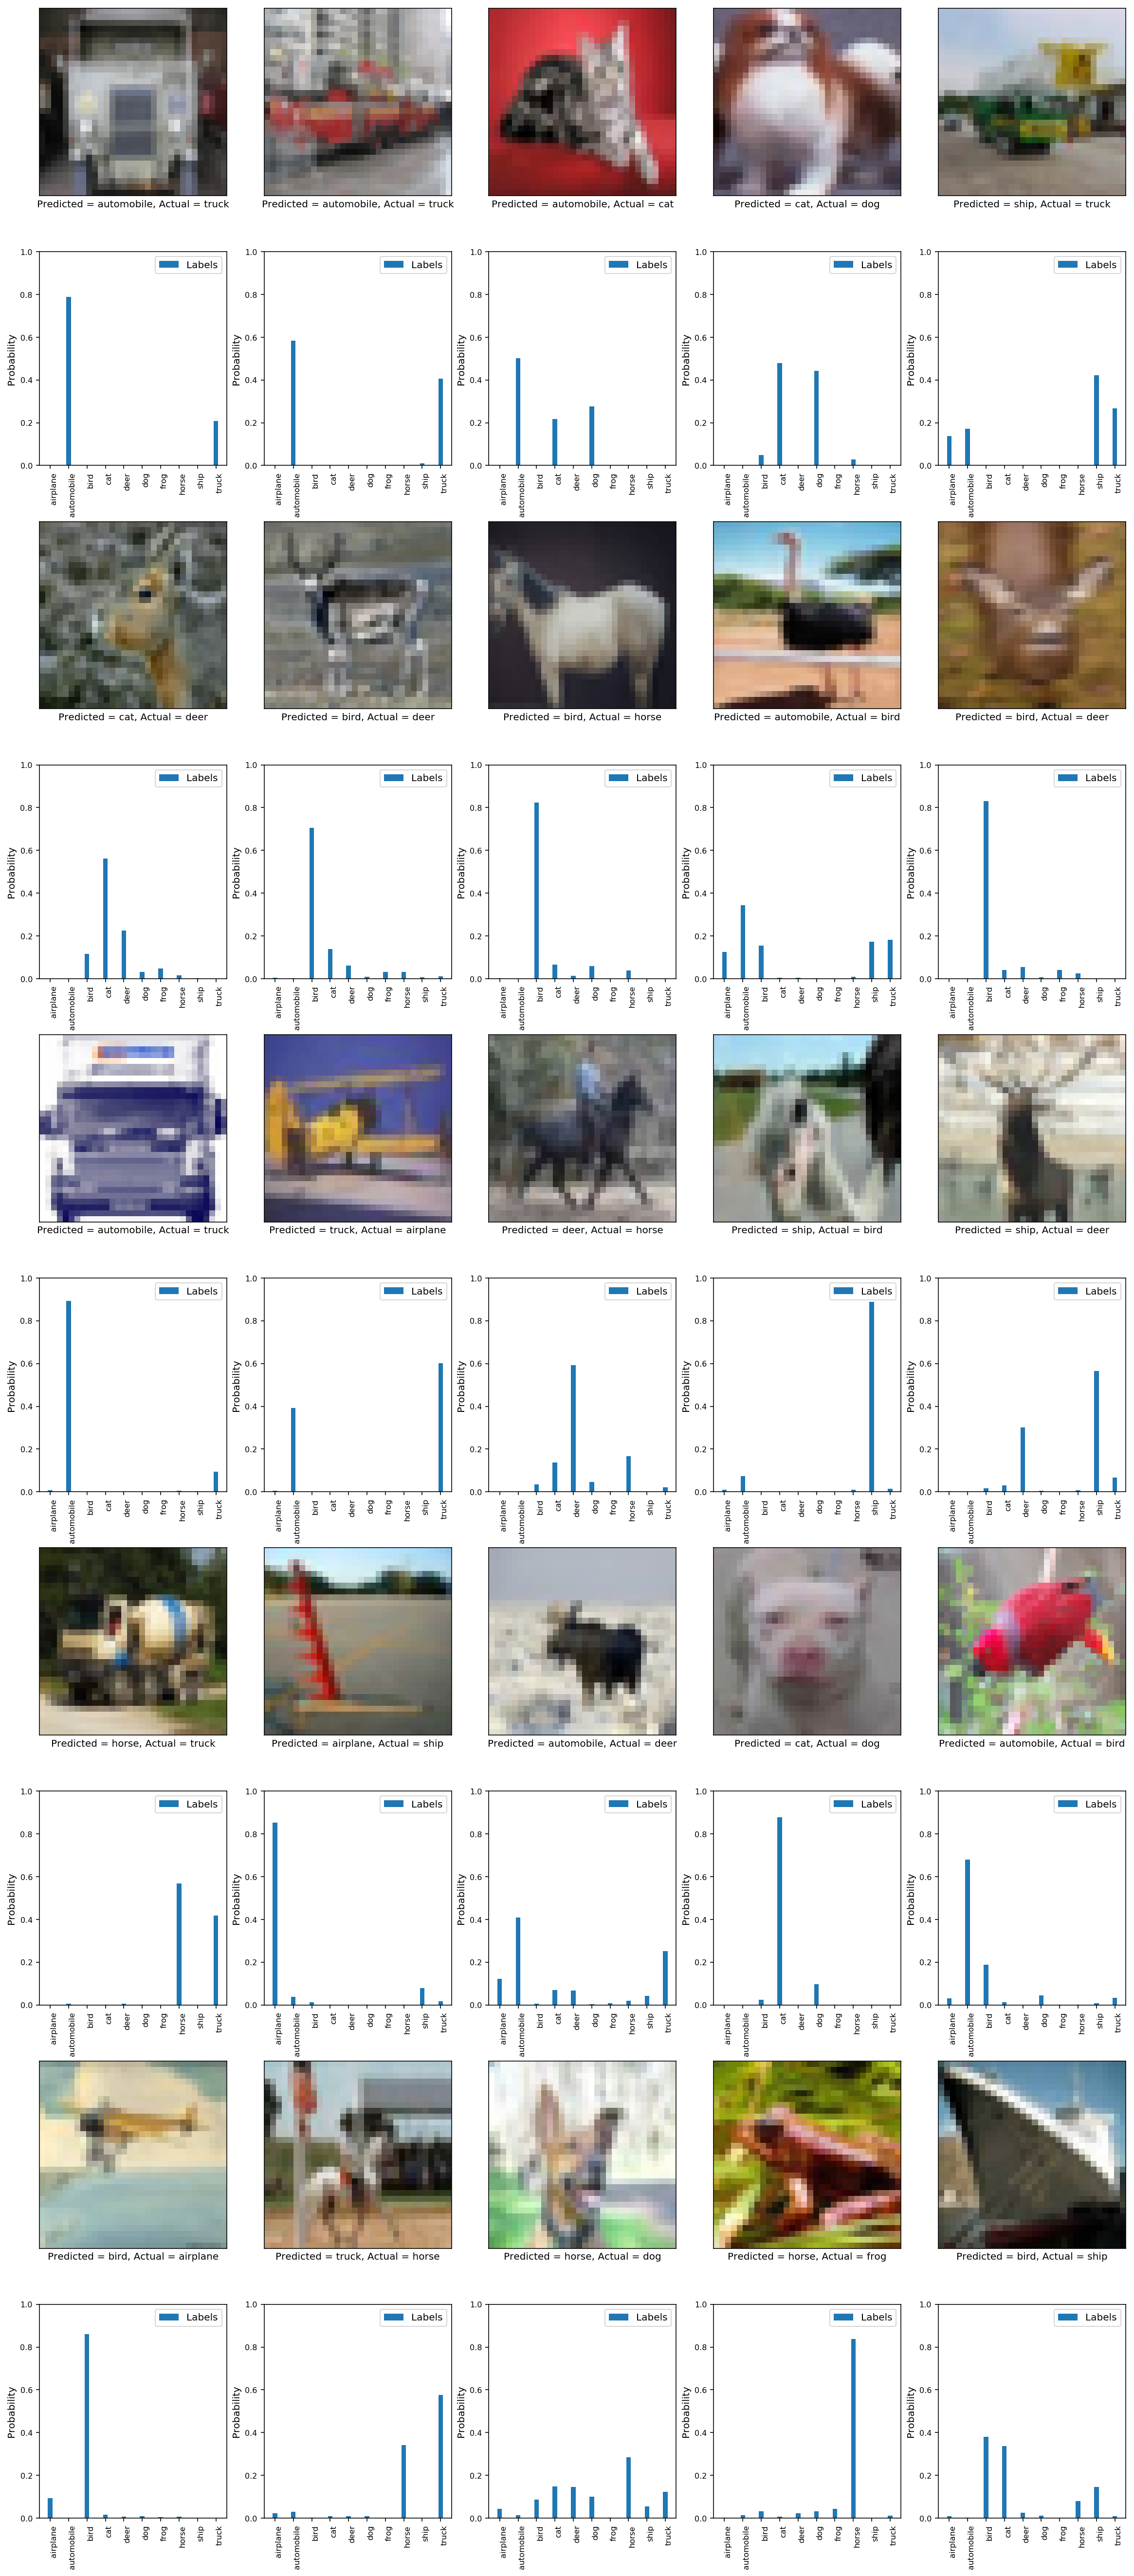

In [50]:
iterator = datagen.flow(x_test, y_test, batch_size=1024, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))

# Above 2 steps are same in Prediction and scoring steps as well

show_misclassified(x_test, y_test, predictions[:len(y_test)], classes=get_cifar10_labels(), 
                       columns=5, total=25, 
                       pick_randomly=True, image_size_multiplier=4)

In [85]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import cv2

In [95]:
img_path_list = ['/content/horse.png','/content/bird.png','/content/cat.png','/content/frog.png']
print(img_path_list)
for i in range(len(img_path_list)):
    img_path = img_path_list[i]
    img = image.load_img(img_path, target_size=(32, 32))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("zero_padding2d_29")
    #last_conv_layer = model.get_layer("block5_conv3")
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(10):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    from google.colab.patches import cv2_imshow
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    numpy_horizontal_concat = np.concatenate((img, superimposed_img), axis=1)
    cv2_imshow(numpy_horizontal_concat)

['/content/horse.png', '/content/bird.png', '/content/cat.png', '/content/frog.png']


FileNotFoundError: ignored